# Evaluation of text similarity metrics using GLUE tasks

This notebook contains an ablation for our results, in which we use a different model for the STSScorer, i.e., a BERT-base model. Plots and intermediate results are not stored to disk, but are shown in the notebook.

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        ### The next line is the only change in the notebook, compared to the original notebook - except for storing plots.
        model_name = 'JeremiahZ/bert-base-uncased-stsb'
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt").to(self.device)
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5
        
sts_scorer = STSScorer()

def fetch_scores(data, feature1, feature2):
    print('Number of instances:',len(data))
    scores = []
    count = 0
    
    # check if data is pd.DataFrame
    if isinstance(data, pd.DataFrame):
        for index, row in data.iterrows():
            scores.append(score_instance(row, feature1, feature2))
            count += 1
            if count % (int(len(data)/10)) == 0:
                print('%i done (%i%%)' % (count, count/len(data)*100))
    else:    
        for instance in data:
            scores.append(score_instance(instance, feature1, feature2))
            count += 1
            if count % (int(len(data)/10)) == 0:
                print('%i done (%i%%)' % (count, count/len(data)*100))
    return scores

def score_instance(instance, feature1, feature2):
    stsb_score = sts_scorer.score(instance[feature1], instance[feature2])
    return {'label': instance['label'], 'sts_score': stsb_score}

In [16]:
import torch
torch.cuda.is_available()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## STS-B

In [21]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_stsb = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))

Number of instances: 1379
137 done (9%)
274 done (19%)
411 done (29%)
548 done (39%)
685 done (49%)
822 done (59%)
959 done (69%)
1096 done (79%)
1233 done (89%)
1370 done (99%)


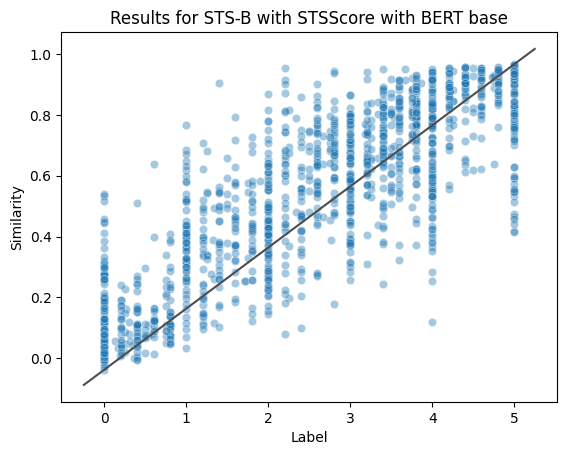

Pearson correlation


sts_score    0.832859
Name: label, dtype: float64

Spearman correlation


sts_score    0.817618
Name: label, dtype: float64

In [22]:
def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

ax = sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4)
draw_diagonal(ax)
ax.set_ylabel("Similarity")
ax.set_xlabel("Label")
ax.set_title("Results for STS-B with STSScore with BERT base")

fig.tight_layout()
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson')['label'][['sts_score']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman')['label'][['sts_score']])

## MRPC

In [23]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))

Number of instances: 1725
172 done (9%)
344 done (19%)
516 done (29%)
688 done (39%)
860 done (49%)
1032 done (59%)
1204 done (69%)
1376 done (79%)
1548 done (89%)
1720 done (99%)


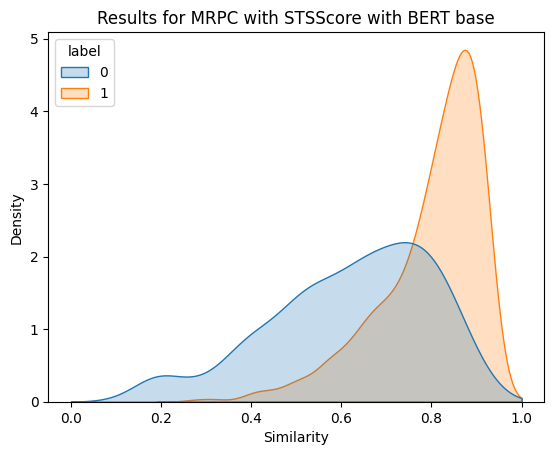

Mean


,sts_score
label,
0,0.621745
1,0.797854


Standard deviation


,sts_score
label,
0,0.178086
1,0.114431


In [24]:
ax = sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1])

ax.set_xlabel("Similarity")
ax.set_title("Results for MRPC with STSScore with BERT base")

sns.move_legend(ax, "upper left")
fig.tight_layout()
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())

## QQP

In [25]:
data = load_dataset('glue', 'qqp')['train']
scores_qqp = pd.DataFrame(fetch_scores(data, 'question1', 'question2'))

Number of instances: 363846
36384 done (9%)
72768 done (19%)
109152 done (29%)
145536 done (39%)
181920 done (49%)
218304 done (59%)
254688 done (69%)
291072 done (79%)
327456 done (89%)
363840 done (99%)


In [26]:
ax = sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

ax.set_xlabel("Similarity")
ax.set_title("Results for QQP with STSScore with BERT base")

sns.move_legend(ax, "upper left")
fig.tight_layout()
plt.show()

print('Mean')
display(scores_qqp.groupby('label').mean())
print('Standard deviation')
display(scores_qqp.groupby('label').std())

Mean


,sts_score
label,
0,0.460791
1,0.694752


Standard deviation


,sts_score
label,
0,0.230739
1,0.147145


# AUC Analysis for MRPC and QQP

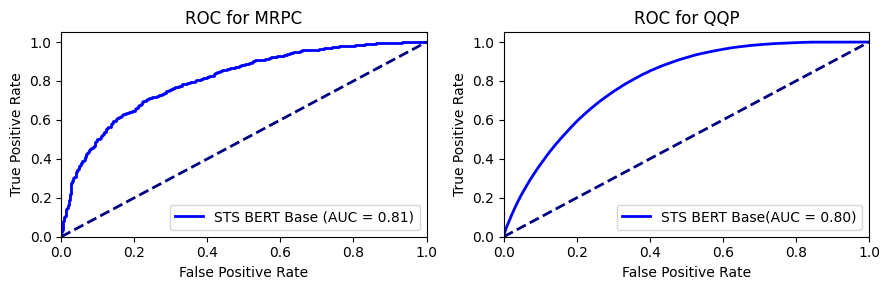

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

# Plot the ROC curve vor MRPC
# Compute the false positive rate, true positive rate, and thresholds
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_mrpc['label'], scores_mrpc['sts_score'])

# Compute the area under the ROC curve
roc_auc_sts = auc(fpr_sts, tpr_sts)

axes[0].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS BERT Base (AUC = %0.2f)' % roc_auc_sts)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC for MRPC')
axes[0].legend(loc="lower right")

# Plot the ROC curve for qqp
# Compute the false positive rate, true positive rate, and thresholds
fpr_sts, tpr_sts, thresholds_sts = roc_curve(scores_qqp['label'], scores_qqp['sts_score'])

# Compute the area under the ROC curve
roc_auc_sts = auc(fpr_sts, tpr_sts)

# Plot the ROC curve
axes[1].plot(fpr_sts, tpr_sts, color='blue', lw=2, label='STS BERT Base(AUC = %0.2f)' % roc_auc_sts)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC for QQP')
axes[1].legend(loc="lower right")
fig.tight_layout()
plt.show()

# WMT-22-ZH-EN

In [28]:
#langs = ['cs-en', 'de-en', 'liv-en', 'ru-en', 'uk-en', 'zh-en']
#best_refs = ['refB', 'refA', 'refA', 'refA', 'refA', 'refA']
#human_ratings = ['wmt', 'wmt', 'wmt-appraise', 'wmt', 'wmt', 'mqm']

langs = ['zh-en']
best_refs = ['refA']
human_ratings = ['mqm']

all_scores = None
for lang, best_ref, human_rating in zip(langs, best_refs, human_ratings):
    with open('data/wmt22/sources/%s.txt' % lang) as f:
        sources = f.read().splitlines()
    with open('data/wmt22/references/%s.%s.txt' % (lang, best_ref)) as f:
        references = f.read().splitlines()

    human_scores = pd.read_csv('data/wmt22/human-scores/%s.%s.seg.score' % (lang, human_rating), sep='\t', header=None, names=['system', 'score'])

    folder_path = 'data/wmt22/system-outputs/'+lang
    for file in human_scores['system'].unique():
        with open(folder_path+'/'+file+'.txt') as f:
            translations = f.read().splitlines()
        human_scores.loc[human_scores['system'] == file, 'source'] = sources
        human_scores.loc[human_scores['system'] == file, 'reference'] = references
        human_scores.loc[human_scores['system'] == file, 'translation'] = translations
    human_scores['lang-pair'] = lang
    human_scores['system']
    if all_scores is None:
        all_scores = human_scores
    else:
        all_scores = pd.concat([all_scores, human_scores])

wmt22_df = all_scores.dropna()
wmt22_df = wmt22_df.rename(columns={'score': 'label'})
wmt22_df.dropna(inplace=True)

In [29]:
scores_wmt22 = pd.DataFrame(fetch_scores(wmt22_df, 'reference', 'translation'))

Number of instances: 30000
3000 done (10%)
6000 done (20%)
9000 done (30%)
12000 done (40%)
15000 done (50%)
18000 done (60%)
21000 done (70%)
24000 done (80%)
27000 done (90%)
30000 done (100%)


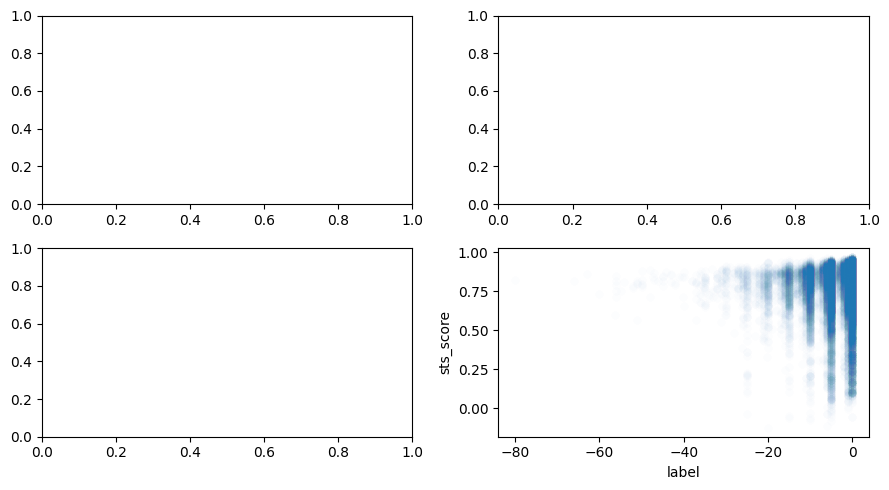

Pearson correlation


label        1.000000
sts_score    0.083886
Name: label, dtype: float64

Spearman correlation


label        1.000000
sts_score    0.181543
Name: label, dtype: float64

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5))
sns.scatterplot(x="label", y="sts_score", data=scores_wmt22, alpha=0.01, ax=axes[1,1])
draw_diagonal(ax)
ax.set_ylabel("Similarity")
ax.set_xlabel("MQM")
ax.set_title("Results for STS-B with STSScore")
fig.tight_layout()
plt.show()

print('Pearson correlation')
display(scores_wmt22[['label', 'sts_score']].corr(method='pearson')['label'])
print('Spearman correlation')
display(scores_wmt22[['label', 'sts_score']].corr(method='spearman')['label'])